In [1]:
# 31-Dec-2016
import numpy as np
import scipy as sp
import os, re, json, csv
import networkx as nx
import matplotlib.pyplot as plt


%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize'] = 7,4 # Bigger figures
rcParams['lines.linewidth'] = 2.0


def NestWhileList(func, arg, stopTestQ, nmax = 1000):
    # stopTestQ takes full FP list to calc stop flag. stop when True
    tmp_lst = [func(arg)]
    tmp_lst = tmp_lst + [func(tmp_lst[-1])]
    while ( not(stopTestQ(tmp_lst)) & (len(tmp_lst) < nmax) ):
        tmp_lst = tmp_lst + [func(tmp_lst[-1])]
    return([list(t) for t in tmp_lst])

def stopcritQ(res_lst):
    res_lst = [str(t) for t in res_lst]
    return( len(set(res_lst))!=len(res_lst) )

def Clamp(actvn, mask):
        assert(len(actvn) == len(mask))
        clamped = actvn
        clamped[ [j for j in range(len(mask)) if mask[j]==1] ] = 1
        clamped[ [j for j in range(len(mask)) if mask[j]<0] ] = 0
        return clamped

class FCM:
    
    def __init__(self, title):
        self.title = title
        self.graph = nx.DiGraph()
        self.ActivationFunction = lambda x: 1*(x>=0.5) #S fxn; use member fxn to update
    
    def add_edges(self, edge_lst):
        self.graph.add_weighted_edges_from(edge_lst)
    
    def label_edges(self, label_dict):
        self.graph = nx.relabel_nodes(self.graph, label_dict, copy=False)
    
    def set_activation(self, actvn):
        self.ActivationFunction = actvn
    def get_FCM_Matrix(self):
        return(nx.adjacency_matrix(self.graph).todense())
    
    def VizFCM(self):
        nx.draw(self.graph, 
                with_labels=True, node_size=700, 
                nodecolor='g', edge_color='b')
        plt.title(self.title)
        
    def EvolveOnce(self, inp, mask):
        assert(len(inp) == len(mask))
        return Clamp( self.ActivationFunction(
                np.asarray(np.matmul(Clamp(inp, mask), 
                                     nx.adjacency_matrix(self.graph).todense())).ravel()
            ), mask)
        
    def EvolveToLimit(self, inp, mask, nmax = 1000):
        assert(len(inp) == len(mask))
        seq = NestWhileList(
            lambda inp_vec: self.EvolveOnce(inp_vec, mask),
            inp, stopcritQ, nmax
        )
        seq = [inp] + seq
        return(np.matrix(seq))
    
#    def VizFCMEvol(self):
        

[1 0 0 1 1 0 0 0 0 0 0 1]
[[1 0 1 0 0 0 0 1 1 1 0 0]
 [1 0 0 1 1 0 0 0 0 0 0 1]
 [1 1 0 1 1 0 0 0 0 0 0 1]
 [1 1 0 1 1 0 0 0 0 0 0 1]]


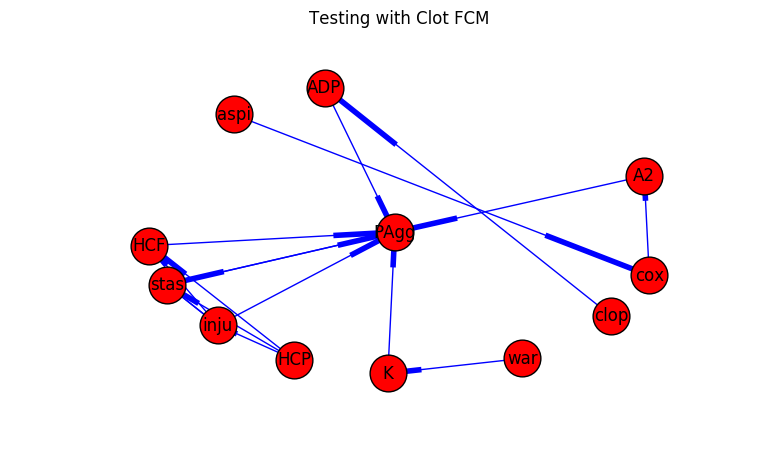

In [2]:
clotlist = [(1, 1, 1), (1, 2, 0.4), (1, 3, 1), (1, 4, 1),
            (2, 3, 0.5), (2, 6, 0.45), (3, 2, 0.4), (3, 4, 0.75),
            (3, 6, 0.4), (4, 6, 0.4), (5, 6, 0.45), (6, 2, 0.7),
            (7, 5, -0.6), (8, 6, 0.95), (9, 10, -0.9), (10, 6, 1),
            (11, 8, 0.95), (12, 11, -0.6)]
mapping = {1:"HCP", 2:"stas", 3:"inju", 
           4:"HCF", 5:"ADP", 6:"PAgg", 
           7:"clop", 8:"A2", 9:"war", 
           10:"K", 11:"cox", 12:"aspi"}
tstfcm = FCM("Testing with Clot FCM")

tstfcm.add_edges(clotlist)
tstfcm.label_edges(mapping)
tstfcm.VizFCM()

vec = np.random.randint(2, size=len(tstfcm.graph.nodes()) )
print tstfcm.EvolveOnce(vec, mask = np.zeros(len(vec)))
print tstfcm.EvolveToLimit(vec, mask = np.zeros(len(vec)))